In [1]:
import pandas as pd
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.model_selection import KFold
import scipy.sparse
from sklearn.svm import SVC

In [4]:
# Load and preprocess the data
df_javascript = pd.read_csv("~/project--eece7205/data/QueryResults_JS.csv")
df_cplusplus = pd.read_csv("~/project--eece7205/data/QueryResults_cplusplus.csv")
df_python = pd.read_csv("~/project--eece7205/data/QueryResults_Python.csv")
df_sql = pd.read_csv("~/project--eece7205/data/QueryResults_SQL.csv")
df_java = pd.read_csv("~/project--eece7205/data/QueryResults_Java.csv")

In [5]:
def merge_add_labels(*args):
    labeled_dfs = [(df.assign(Label=label)) for df, label in args]
    return pd.concat(labeled_dfs, ignore_index=True)

In [6]:
df_labeled = merge_add_labels(
    (df_javascript, "JavaScript"),
    (df_cplusplus, "CPP"),
    (df_python, "Python"),
    (df_sql, "SQL"),
    (df_java, "Java"),
)

In [7]:
def preprocess_text(text):
    text = "".join([char for char in text if char not in string.punctuation])
    text = word_tokenize(text.lower())
    text = [
        WordNetLemmatizer().lemmatize(word)
        for word in text
        if word not in stopwords.words("english")
    ]
    return " ".join(text)

In [8]:
df_labeled["Processed_Text"] = df_labeled["Title"].apply(preprocess_text)

In [9]:
# TF-IDF transformation
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_labeled["Processed_Text"])
y = df_labeled["Label"]

In [10]:
df_cleaned_sep = df_labeled[["Title", "Label"]]

In [11]:
df_cleaned_sep

,Title,Label
0,How can I remove a specific item from an array...,JavaScript
1,How do I check if an element is hidden in jQuery?,JavaScript
2,"What does ""use strict"" do in JavaScript, and w...",JavaScript
3,How do I redirect to another webpage?,JavaScript
4,var functionName = function() {} vs function f...,JavaScript
...,...,...
24995,Get HTTP code from org.apache.http.HttpResponse,Java
24996,Which artifact for org.springframework.mail?,Java
24997,Foreign key constraints in Android using SQLit...,Java
24998,What is Stateless Object in Java?,Java


In [12]:
df_cleaned_sep.to_csv('~/project--eece7205/data/df_cleaned_sep_labeled.csv')

In [13]:
X.shape

(25000, 11241)

In [23]:
def logisticRegressionOut(X, y, save_path='lr.joblib'):
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df_labeled["Label"])

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Train the Logistic Regression model
    model = LogisticRegression(
        solver="saga",
        multi_class="multinomial",
        penalty='l2',
        max_iter=1000,
        n_jobs=-1,
        random_state=42,
    )
    model.fit(X_train, y_train)

    # Predictions and evaluation
    y_pred = model.predict(X_test)
    print(
        "\nClassification Report:\n",
        classification_report(y_test, y_pred, target_names=label_encoder.classes_),
    )

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    # Save the model
    if save_path:
        joblib.dump(
            {"model": model, "label_encoder": label_encoder, "tfidf": tfidf}, save_path
        )
        print(f"Model saved to {save_path}")


Classification Report:
               precision    recall  f1-score   support

         CPP       0.71      0.88      0.79      1000
        Java       0.87      0.80      0.83      1000
  JavaScript       0.88      0.85      0.86      1000
      Python       0.86      0.80      0.83      1000
         SQL       0.94      0.90      0.92      1000

    accuracy                           0.84      5000
   macro avg       0.85      0.84      0.85      5000
weighted avg       0.85      0.84      0.85      5000



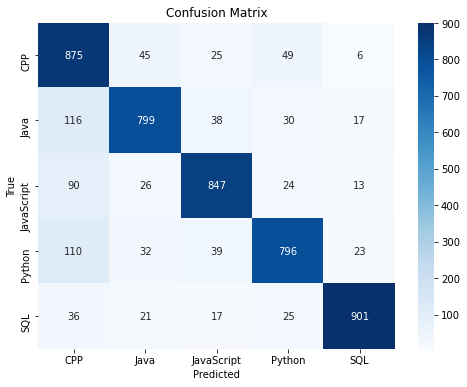

Model saved to lr.joblib


In [24]:
logisticRegressionOut(X, y)

In [25]:
import os
path = os.path.expanduser('~/project--eece7205/models')
print(path)

/home/choudhari.pra/project--eece7205/models


# Random Forest

In [30]:
def randomForestOut(X, y, save_path='randomforest.joblib'):
    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    # Convert y to numpy array if it's not already
    y = np.array(y)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y
    )
    
    # Initialize lists for storing performance metrics
    tree_sizes = [50, 150, 250, 350, 450]
    test_errors = []
    train_errors = []
    f1_scores = []
    auc_scores = []
    imp_features = []
    
    # Setup K-Fold cross validation
    kf = KFold(n_splits=10, shuffle=True)
    
    # Train and evaluate models with different tree sizes
    for tree_size in tree_sizes:
        model = RandomForestClassifier(
            n_estimators=tree_size,
            n_jobs=-1,
            random_state=42,
            bootstrap=True,
            oob_score=True,
            max_depth=20,
            max_features=0.01
        )
        
        # K-Fold Cross Validation
        kf_errors = []
        for train_ind, val_ind in kf.split(X_train):
            # Handle both sparse and dense matrices
            if scipy.sparse.issparse(X_train):
                X_train_kf = X_train[train_ind]
                X_val = X_train[val_ind]
            else:
                X_train_kf = X_train.iloc[train_ind]
                X_val = X_train.iloc[val_ind]
            
            y_train_kf = y_train[train_ind]
            y_val = y_train[val_ind]
            
            model.fit(X_train_kf, y_train_kf)
            y_pred_val = model.predict(X_val)
            kf_error = 1 - accuracy_score(y_val, y_pred_val)
            kf_errors.append(kf_error)
        
        # Fit the model on full training data
        model.fit(X_train, y_train)
        
        # Calculate performance metrics
        y_pred = model.predict(X_test)
        test_error = 1 - accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        # For multi-class, we need to use different approach for ROC AUC
        y_pred_proba = model.predict_proba(X_test)
        auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
        
        # Store metrics
        test_errors.append(test_error)
        train_errors.append(np.mean(kf_errors))
        f1_scores.append(f1)
        auc_scores.append(auc_score)
        
        # Get feature importances
        feature_importances = model.feature_importances_
        indices = np.argsort(feature_importances)[::-1]
        imp_features.append(indices[:10])
    
    # Print classification report for the final model
    print(
        "\nClassification Report:\n",
        classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    )
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Plot error metrics
    plt.figure(figsize=(10, 6))
    plt.plot(tree_sizes, test_errors, label="Test error")
    plt.plot(tree_sizes, train_errors, label="Train error")
    plt.plot(tree_sizes, f1_scores, label="F1 score")
    plt.plot(tree_sizes, auc_scores, label="ROC AUC")
    plt.xlabel("Number of Trees")
    plt.ylabel("Score")
    plt.title("Model Performance vs Number of Trees")
    plt.legend()
    plt.show()
    
    # Save the model
    if save_path:
        joblib.dump(
            {
                "model": model,
                "label_encoder": label_encoder,
                "feature_importances": feature_importances
            },
            save_path
        )
        print(f"Model saved to {save_path}")
    
    return model, label_encoder

In [ ]:
randomForestOut(X, y)

# Support Vector Machines

In [ ]:
def svmOut(X, y, save_path='svm.joblib'):
    """
    Trains and evaluates an SVM classifier with a single optimized configuration.
    
    Parameters:
    X : feature matrix (can be sparse or dense)
    y : target labels
    save_path : optional path to save the model
    """
    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    # Convert y to numpy array if it's not already
    y = np.array(y)
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y
    )
    
    # Initialize model with optimized configuration
    model = SVC(
        kernel='rbf',  # RBF kernel generally performs well
        C=1.0,        # Good default value
        probability=True,
        random_state=42
    )
    
    # Setup K-Fold cross validation
    kf = KFold(n_splits=5, shuffle=True)  # Reduced from 10 to 5 folds
    
    # K-Fold Cross Validation
    kf_errors = []
    for train_ind, val_ind in kf.split(X_train):
        # Handle both sparse and dense matrices
        if scipy.sparse.issparse(X_train):
            X_train_kf = X_train[train_ind]
            X_val = X_train[val_ind]
        else:
            X_train_kf = X_train.iloc[train_ind]
            X_val = X_train.iloc[val_ind]
        
        y_train_kf = y_train[train_ind]
        y_val = y_train[val_ind]
        
        model.fit(X_train_kf, y_train_kf)
        y_pred_val = model.predict(X_val)
        kf_error = 1 - accuracy_score(y_val, y_pred_val)
        kf_errors.append(kf_error)
    
    # Fit the model on full training data
    model.fit(X_train, y_train)
    
    # Calculate performance metrics
    y_pred = model.predict(X_test)
    test_error = 1 - accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    y_pred_proba = model.predict_proba(X_test)
    auc_score = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
    
    # Print performance metrics
    print("\nPerformance Metrics:")
    print(f"Test Error: {test_error:.4f}")
    print(f"Cross-validation Error: {np.mean(kf_errors):.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC Score: {auc_score:.4f}")
    
    # Print classification report
    print(
        "\nClassification Report:\n",
        classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    )
    
    # Plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Save the model
    if save_path:
        joblib.dump(
            {
                "model": model,
                "label_encoder": label_encoder
            },
            save_path
        )
        print(f"Model saved to {save_path}")
    
    return model, label_encoder

In [ ]:
svmOut(X, y)

# Neural Network

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset

class CustomNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomNN, self).__init__()
        
        # Define architecture
        self.network = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_size // 2, num_classes)
        )
        
        # Initialize weights randomly
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                nn.init.zeros_(module.bias)
    
    def forward(self, x):
        return self.network(x)

def neuralNetOut(X, y, save_path='nn.joblib', epochs=100, batch_size=32, learning_rate=0.001, hidden_size=128):
    """
    Train and evaluate a neural network with cross-validation
    """
    # Convert data to numpy if it's sparse
    if scipy.sparse.issparse(X):
        X = X.toarray()
    
    # Encode labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    num_classes = len(label_encoder.classes_)
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(X_scaled)
    y_tensor = torch.LongTensor(y)
    
    # Setup k-fold cross validation
    k_folds = 5
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    
    # Store results
    fold_results = []
    best_model = None
    best_accuracy = 0
    
    # For plotting
    train_losses = []
    val_losses = []
    
    # Cross validation loop
    for fold, (train_ids, val_ids) in enumerate(kfold.split(X_tensor)):
        print(f'\nFOLD {fold+1}/{k_folds}')
        
        # Sample data for this fold
        X_train_fold = X_tensor[train_ids]
        y_train_fold = y_tensor[train_ids]
        X_val_fold = X_tensor[val_ids]
        y_val_fold = y_tensor[val_ids]
        
        # Create data loaders
        train_dataset = TensorDataset(X_train_fold, y_train_fold)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # Initialize model
        model = CustomNN(input_size=X.shape[1], hidden_size=hidden_size, num_classes=num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        
        # Training loop
        fold_train_losses = []
        fold_val_losses = []
        
        for epoch in range(epochs):
            model.train()
            total_train_loss = 0
            for batch_X, batch_y in train_loader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
                total_train_loss += loss.item()
            
            # Validation
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_fold)
                val_loss = criterion(val_outputs, y_val_fold)
                val_pred = torch.argmax(val_outputs, dim=1)
                accuracy = accuracy_score(y_val_fold, val_pred)
            
            # Store losses
            avg_train_loss = total_train_loss / len(train_loader)
            fold_train_losses.append(avg_train_loss)
            fold_val_losses.append(val_loss.item())
            
            # Scheduler step
            scheduler.step(val_loss)
            
            if (epoch + 1) % 10 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')
        
        # Store fold results
        fold_results.append(accuracy)
        
        # Update best model
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model.state_dict()
        
        train_losses.append(fold_train_losses)
        val_losses.append(fold_val_losses)
    
    print('\nCross-validation Results:')
    for fold, accuracy in enumerate(fold_results):
        print(f'Fold {fold+1}: {accuracy:.4f}')
    print(f'Average accuracy: {np.mean(fold_results):.4f} ± {np.std(fold_results):.4f}')
    
    # Create final model with best weights
    final_model = CustomNN(input_size=X.shape[1], hidden_size=hidden_size, num_classes=num_classes)
    final_model.load_state_dict(best_model)
    
    # Final evaluation
    final_model.eval()
    with torch.no_grad():
        y_pred = torch.argmax(final_model(X_tensor), dim=1).numpy()
    
    # Print final report
    print('\nFinal Classification Report:')
    print(classification_report(y, y_pred, target_names=label_encoder.classes_))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Plot training curves
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    for fold in range(k_folds):
        plt.plot(train_losses[fold], label=f'Fold {fold+1}')
    plt.title('Training Loss per Fold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    for fold in range(k_folds):
        plt.plot(val_losses[fold], label=f'Fold {fold+1}')
    plt.title('Validation Loss per Fold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # Save the model
    if save_path:
        torch.save({
            'model_state_dict': final_model.state_dict(),
            'scaler': scaler,
            'label_encoder': label_encoder,
            'model_config': {
                'input_size': X.shape[1],
                'hidden_size': hidden_size,
                'num_classes': num_classes
            }
        }, save_path)
        print(f'\nModel saved to {save_path}')
    
    return final_model, scaler, label_encoder

# Function to make predictions
def predict_with_nn(X, model_path):
    """
    Make predictions using the saved neural network model
    """
    # Load saved model and objects
    checkpoint = torch.load(model_path)
    
    # Initialize model with saved configuration
    model = CustomNN(
        input_size=checkpoint['model_config']['input_size'],
        hidden_size=checkpoint['model_config']['hidden_size'],
        num_classes=checkpoint['model_config']['num_classes']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Preprocess input
    X_scaled = checkpoint['scaler'].transform(X)
    X_tensor = torch.FloatTensor(X_scaled)
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(X_tensor)
        predictions = torch.argmax(outputs, dim=1).numpy()
    
    # Convert back to original labels
    original_labels = checkpoint['label_encoder'].inverse_transform(predictions)
    
    return original_labels

In [ ]:
neuralNetOut(X, y)

# Distil BERT

In [101]:
!pip install transformers

Python(43816) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


You should consider upgrading via the '/Users/pradnyeshchoudhari/EECE 7205 - LOCAL/Project/eece7205/bin/python3.8 -m pip install --upgrade pip' command.


In [102]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm import tqdm

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        Focal Loss implementation
        
        Args:
            alpha (tensor): Weighting factor for each class, helps with class imbalance
            gamma (float): Focusing parameter. Higher gamma reduces the loss for well-classified examples
            reduction (str): 'mean' or 'sum'
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.alpha = alpha
        
        if alpha is not None:
            self.alpha = torch.tensor(alpha)
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        
        # Apply class weights if provided
        if self.alpha is not None:
            self.alpha = self.alpha.to(inputs.device)
            at = self.alpha.gather(0, targets)
            focal_loss = at * (1 - pt) ** self.gamma * ce_loss
        else:
            focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        else:
            return focal_loss.sum()

class BERTTagPredictor(nn.Module):
    def __init__(self, n_tags, dropout=0.3):
        super(BERTTagPredictor, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, n_tags)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

def calculate_class_weights(y_train):
    """Calculate class weights based on inverse frequency"""
    classes, counts = np.unique(y_train, return_counts=True)
    total_samples = len(y_train)
    weights = total_samples / (len(classes) * counts)
    return weights / weights.sum()  # Normalize weights

# def train_model(X_train, y_train, X_val, y_val, n_epochs=5, batch_size=16, learning_rate=2e-5):
#     tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
#     n_tags = len(np.unique(y_train))
#     model = BERTTagPredictor(n_tags=n_tags)
    
#     # Calculate class weights for focal loss
#     class_weights = calculate_class_weights(y_train)
    
#     # Initialize focal loss with class weights
#     criterion = FocalLoss(alpha=class_weights, gamma=2.0)
    
#     device = 'cpu'
#     model.to(device)
#     criterion.to(device)
    
#     # Create datasets and dataloaders
#     train_dataset = StackOverflowTagDataset(X_train, y_train, tokenizer)
#     val_dataset = StackOverflowTagDataset(X_val, y_val, tokenizer)
    
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
#     optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
#     # Training loop
#     best_val_acc = 0
#     patience = 3
#     patience_counter = 0
    
#     for epoch in range(n_epochs):
#         model.train()
#         total_loss = 0
        
#         for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{n_epochs}'):
#             optimizer.zero_grad()
            
#             input_ids = batch['input_ids'].to(device)
#             attention_mask = batch['attention_mask'].to(device)
#             tags = batch['tags'].to(device)
            
#             outputs = model(input_ids, attention_mask)
#             loss = criterion(outputs, tags)
            
#             loss.backward()
#             optimizer.step()
            
#             total_loss += loss.item()
        
#         # Validation
#         model.eval()
#         val_predictions = []
#         val_labels = []
#         val_loss = 0
        
#         with torch.no_grad():
#             for batch in val_loader:
#                 input_ids = batch['input_ids'].to(device)
#                 attention_mask = batch['attention_mask'].to(device)
#                 tags = batch['tags'].to(device)
                
#                 outputs = model(input_ids, attention_mask)
#                 val_loss += criterion(outputs, tags).item()
                
#                 _, predictions = torch.max(outputs, 1)
#                 val_predictions.extend(predictions.cpu().numpy())
#                 val_labels.extend(tags.cpu().numpy())
        
#         # Calculate metrics
#         val_accuracy = accuracy_score(val_labels, val_predictions)
#         val_report = classification_report(val_labels, val_predictions)
        
#         print(f'\nEpoch {epoch + 1}:')
#         print(f'Training loss: {total_loss / len(train_loader):.4f}')
#         print(f'Validation loss: {val_loss / len(val_loader):.4f}')
#         print(f'Validation Accuracy: {val_accuracy:.4f}')
#         print('\nClassification Report:')
#         print(val_report)
        
#         # Early stopping with patience
#         if val_accuracy > best_val_acc:
#             best_val_acc = val_accuracy
#             torch.save(model.state_dict(), 'best_model.pth')
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print(f'\nEarly stopping triggered after {epoch + 1} epochs')
#                 break
    
#     return model

def predict_tags(model, texts, tokenizer, device):
    """Predict tags for new texts"""
    model.eval()
    predictions = []
    
    dataset = StackOverflowTagDataset(texts, np.zeros(len(texts)), tokenizer)
    dataloader = DataLoader(dataset, batch_size=16)
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    
    return np.array(predictions)

# Example usage
if __name__ == "__main__":
    # Example of preparing your data:
    # Assuming you have:
    # X = ["preprocessed text 1", "preprocessed text 2", ...]
    # y = [0, 1, 2, ...]  # Integer labels for each tag
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder
    
    # Encode tags if they're not already integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42
    )
    
    # Train the model
    model = train_model(X_train, y_train, X_val, y_val)
    
    # Make predictions on new data
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    new_texts = ["example question 1", "example question 2"]
    predictions = predict_tags(model, new_texts, tokenizer, device)
    
    # Convert predictions back to original tag names
    predicted_tags = label_encoder.inverse_transform(predictions)

IndexError: tuple index out of range

In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm import tqdm

class StackOverflowTagDataset(Dataset):
    def __init__(self, texts, tags, tokenizer, max_length=512):
        self.texts = texts
        self.tags = tags
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'tags': torch.tensor(self.tags[idx], dtype=torch.long)  # Changed to long for CrossEntropy
        }

class BERTTagPredictor(nn.Module):
    def __init__(self, n_tags, dropout=0.3):
        super(BERTTagPredictor, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, n_tags)  # 768 is BERT's hidden size
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use CLS token
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

def train_model(X_train, y_train, X_val, y_val, n_epochs=5, batch_size=16, learning_rate=2e-5):
    # Initialize tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    n_tags = len(np.unique(y_train))
    model = BERTTagPredictor(n_tags=n_tags)
    
    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    
    # Create datasets and dataloaders
    train_dataset = StackOverflowTagDataset(X_train, y_train, tokenizer)
    val_dataset = StackOverflowTagDataset(X_val, y_val, tokenizer)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Initialize optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()  # Changed to CrossEntropyLoss
    
    # Training loop
    best_val_acc = 0
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch + 1}/{n_epochs}'):
            optimizer.zero_grad()
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            tags = batch['tags'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, tags)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Validation
        model.eval()
        val_predictions = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                tags = batch['tags']
                
                outputs = model(input_ids, attention_mask)
                _, predictions = torch.max(outputs, 1)
                
                val_predictions.extend(predictions.cpu().numpy())
                val_labels.extend(tags.numpy())
        
        # Calculate metrics
        val_accuracy = accuracy_score(val_labels, val_predictions)
        val_report = classification_report(val_labels, val_predictions)
        
        print(f'\nEpoch {epoch + 1}:')
        print(f'Average training loss: {total_loss / len(train_loader):.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')
        print('\nClassification Report:')
        print(val_report)
        
        # Save best model
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
    
    return model

def predict_tags(model, texts, tokenizer, device):
    """Predict tags for new texts"""
    model.eval()
    predictions = []
    
    dataset = StackOverflowTagDataset(texts, np.zeros(len(texts)), tokenizer)
    dataloader = DataLoader(dataset, batch_size=16)
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
    
    return np.array(predictions)

# Example usage
if __name__ == "__main__":
    # Example of preparing your data:
    # Assuming you have:
    # X = ["preprocessed text 1", "preprocessed text 2", ...]
    # y = [0, 1, 2, ...]  # Integer labels for each tag
    
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder
    
    # Encode tags if they're not already integers
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42
    )
    
    # Train the model
    model = train_model(X_train, y_train, X_val, y_val)
    
    # Make predictions on new data
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    new_texts = ["example question 1", "example question 2"]
    predictions = predict_tags(model, new_texts, tokenizer, device)
    
    # Convert predictions back to original tag names
    predicted_tags = label_encoder.inverse_transform(predictions)

In [ ]:
import torch
import torch.nn as nn
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from tqdm import tqdm

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        """
        Focal Loss implementation
        
        Args:
            alpha (tensor): Weighting factor for each class, helps with class imbalance
            gamma (float): Focusing parameter. Higher gamma reduces the loss for well-classified examples
            reduction (str): 'mean' or 'sum'
        """
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.reduction = reduction
        self.alpha = alpha
        
        if alpha is not None:
            self.alpha = torch.tensor(alpha)
    
    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        
        # Apply class weights if provided
        if self.alpha is not None:
            self.alpha = self.alpha.to(inputs.device)
            at = self.alpha.gather(0, targets)
            focal_loss = at * (1 - pt) ** self.gamma * ce_loss
        else:
            focal_loss = (1 - pt) ** self.gamma * ce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        else:
            return focal_loss.sum()

class BERTTagPredictor(nn.Module):
    def __init__(self, n_tags, dropout=0.3):
        super(BERTTagPredictor, self).__init__()
        self.bert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(768, n_tags)  # 768 is BERT's hidden size
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0, :]  # Use CLS token
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)


def train_model(X, y, n_epochs=5, batch_size=16, learning_rate=2e-5):
    """
    Train model using preprocessed X and y data directly
    
    Args:
        X_train: List/array of preprocessed text strings
        y_train: Array of integer labels
        X_val: List/array of preprocessed text strings
        y_val: Array of integer labels
    """
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    
    # Convert y to numpy array if it's not already
    y = np.array(y)
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=0.2, stratify=y
    )


    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    n_tags = len(np.unique(y_train))
    model = BERTTagPredictor(n_tags=n_tags)
    
    # Calculate class weights for focal loss
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    criterion = FocalLoss(alpha=class_weights, gamma=2.0)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    criterion.to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    # Training loop
    best_val_acc = 0
    patience = 3
    patience_counter = 0
    
    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        
        # Process training data in batches
        num_batches = X_train.shape[0] // batch_size + (1 if X_train.shape[0] % batch_size != 0 else 0)
        
        for i in tqdm(range(num_batches), desc=f'Epoch {epoch + 1}/{n_epochs}'):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, X_train.shape[0])
            
            # Get batch of texts and labels
            batch_texts = X_train[start_idx:end_idx]
            batch_labels = y_train[start_idx:end_idx]
            
            # Tokenize batch
            encodings = tokenizer(
                batch_texts,
                add_special_tokens=True,
                max_length=512,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            
            # Move everything to device
            input_ids = encodings['input_ids'].to(device)
            attention_mask = encodings['attention_mask'].to(device)
            labels = torch.tensor(batch_labels, dtype=torch.long).to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
        
        # Validation
        model.eval()
        val_predictions = []
        val_loss = 0
        
        # Process validation data in batches
        num_val_batches = X_val.shape[0] // batch_size + (1 if X_val.shape[0] % batch_size != 0 else 0)
        
        with torch.no_grad():
            for i in range(num_val_batches):
                start_idx = i * batch_size
                end_idx = min((i + 1) * batch_size, X_val.shape[0])
                
                # Get batch of texts and labels
                batch_texts = X_val[start_idx:end_idx]
                batch_labels = y_val[start_idx:end_idx]
                
                # Tokenize batch
                encodings = tokenizer(
                    batch_texts,
                    add_special_tokens=True,
                    max_length=512,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                
                input_ids = encodings['input_ids'].to(device)
                attention_mask = encodings['attention_mask'].to(device)
                labels = torch.tensor(batch_labels, dtype=torch.long).to(device)
                
                outputs = model(input_ids, attention_mask)
                val_loss += criterion(outputs, labels).item()
                
                _, predictions = torch.max(outputs, 1)
                val_predictions.extend(predictions.cpu().numpy())
        
        # Calculate metrics
        val_accuracy = accuracy_score(y_val, val_predictions)
        val_report = classification_report(y_val, val_predictions)
        
        print(f'\nEpoch {epoch + 1}:')
        print(f'Training loss: {total_loss / num_batches:.4f}')
        print(f'Validation loss: {val_loss / num_val_batches:.4f}')
        print(f'Validation Accuracy: {val_accuracy:.4f}')
        print('\nClassification Report:')
        print(val_report)
        
        # Early stopping with patience
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            torch.save(model.state_dict(), 'best_model.pth')
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\nEarly stopping triggered after {epoch + 1} epochs')
                break
    
    return model

# Example usage with your preprocessed data
if __name__ == "__main__":
    # Assuming you already have:
    # X: your preprocessed text data
    # y: your integer-encoded labels
    
    # Train the model directly with your data
    model = train_model(X, y)
    
    # Make predictions on new data
    def predict(model, texts, tokenizer, device):
        model.eval()
        predictions = []
        
        # Process in batches
        batch_size = 16
        num_batches = len(texts) // batch_size + (1 if len(texts) % batch_size != 0 else 0)
        
        with torch.no_grad():
            for i in range(num_batches):
                start_idx = i * batch_size
                end_idx = min((i + 1) * batch_size, len(texts))
                batch_texts = texts[start_idx:end_idx]
                
                encodings = tokenizer(
                    batch_texts,
                    add_special_tokens=True,
                    max_length=512,
                    padding='max_length',
                    truncation=True,
                    return_tensors='pt'
                )
                
                input_ids = encodings['input_ids'].to(device)
                attention_mask = encodings['attention_mask'].to(device)
                
                outputs = model(input_ids, attention_mask)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
        
        return np.array(predictions)

Epoch 1/5:   0%|          | 0/625 [00:00<?, ?it/s]


ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [103]:
import torch
import torch.nn as nn
import numpy as np
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import scipy.sparse as sp

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        # Convert sparse matrix to dense numpy array if needed
        if sp.issparse(texts):
            self.texts = texts.toarray()
        else:
            self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return self.texts.shape[0]
    
    def __getitem__(self, idx):
        # Convert numerical features to text format
        # Assuming the features are meaningful numbers that we want to preserve
        text = ' '.join(map(str, self.texts[idx]))
        
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

class DistilBERTClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.distilbert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # Use [CLS] token
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

def distilbertClassifierOut(X, y, save_path=None, batch_size=16, epochs=3, learning_rate=2e-5):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Label encoding
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    n_classes = len(label_encoder.classes_)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    # Initialize tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBERTClassifier(n_classes).to(device)
    
    # Create datasets and dataloaders
    train_dataset = TextDataset(X_train, y_train, tokenizer)
    test_dataset = TextDataset(X_test, y_test, tokenizer)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0  # Set to 0 for debugging
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size,
        num_workers=0  # Set to 0 for debugging
    )
    
    # Initialize optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = FocalLoss()
    
    # Training loop
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        
        for batch_idx, batch in enumerate(train_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            if batch_idx % 10 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')
        
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')
    
    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Print classification report
    print("\nClassification Report:\n",
          classification_report(all_labels, all_preds, 
                             target_names=label_encoder.classes_))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Save the model and tokenizer
    if save_path:
        model_dict = {
            "model_state_dict": model.state_dict(),
            "label_encoder": label_encoder,
            "tokenizer": tokenizer,
        }
        torch.save(model_dict, save_path)
        print(f"Model saved to {save_path}")
    
    return model, tokenizer, label_encoder

Using device: cpu
Training set shape: (512, 1067)
Test set shape: (128, 1067)
Epoch 1/3, Batch 0/32, Loss: 1.0600
Epoch 1/3, Batch 10/32, Loss: 0.9829
Epoch 1/3, Batch 20/32, Loss: 1.1347
Epoch 1/3, Batch 30/32, Loss: 1.0916
Epoch 1/3, Average Loss: 1.0700
Epoch 2/3, Batch 0/32, Loss: 1.0383
Epoch 2/3, Batch 10/32, Loss: 0.9825
Epoch 2/3, Batch 20/32, Loss: 1.0300
Epoch 2/3, Batch 30/32, Loss: 1.0235
Epoch 2/3, Average Loss: 1.0400
Epoch 3/3, Batch 0/32, Loss: 1.0792
Epoch 3/3, Batch 10/32, Loss: 1.1250
Epoch 3/3, Batch 20/32, Loss: 1.0521
Epoch 3/3, Batch 30/32, Loss: 1.0627
Epoch 3/3, Average Loss: 1.0407


/Users/pradnyeshchoudhari/EECE 7205 - LOCAL/Project/eece7205/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pradnyeshchoudhari/EECE 7205 - LOCAL/Project/eece7205/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pradnyeshchoudhari/EECE 7205 - LOCAL/Project/eece7205/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete


Classification Report:
               precision    recall  f1-score   support

         CPP       0.00      0.00      0.00        26
        Java       0.20      1.00      0.33        25
  JavaScript       0.00      0.00      0.00        26
      Python       0.00      0.00      0.00        26
         SQL       0.00      0.00      0.00        25

    accuracy                           0.20       128
   macro avg       0.04      0.20      0.07       128
weighted avg       0.04      0.20      0.06       128



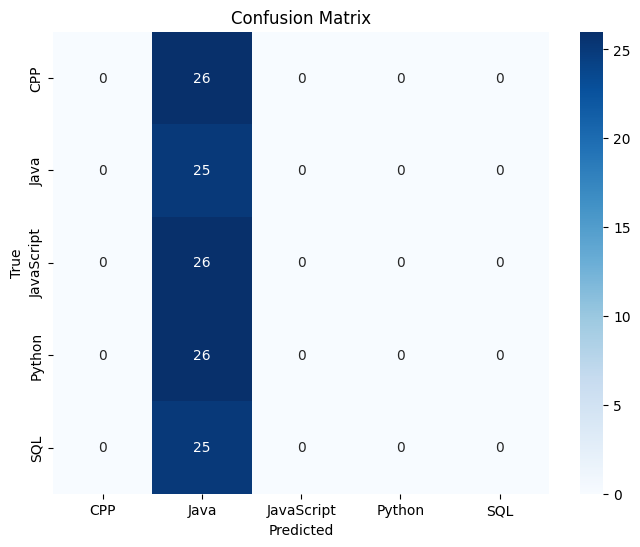

(DistilBERTClassifier(
   (distilbert): DistilBertModel(
     (embeddings): Embeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (transformer): Transformer(
       (layer): ModuleList(
         (0-5): 6 x TransformerBlock(
           (attention): DistilBertSdpaAttention(
             (dropout): Dropout(p=0.1, inplace=False)
             (q_lin): Linear(in_features=768, out_features=768, bias=True)
             (k_lin): Linear(in_features=768, out_features=768, bias=True)
             (v_lin): Linear(in_features=768, out_features=768, bias=True)
             (out_lin): Linear(in_features=768, out_features=768, bias=True)
           )
           (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
           (ffn): FFN(
             (dropout): Dropout(p=0.1, inplace=F

In [104]:
distilbertClassifierOut(X, y)

In [105]:
import torch
import torch.nn as nn
import numpy as np
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
import time
from datetime import datetime

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        ce_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-ce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * ce_loss
        return focal_loss.mean()

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        if sp.issparse(texts):
            self.texts = texts.toarray()
        else:
            self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return self.texts.shape[0]
    
    def __getitem__(self, idx):
        text = ' '.join(map(str, self.texts[idx]))
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

class DistilBERTClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.distilbert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

def distilbertClassifierOut(X, y, save_path=None, batch_size=128, epochs=2, learning_rate=2e-5):
    start_time = time.time()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Label encoding
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    n_classes = len(label_encoder.classes_)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    print(f"Number of classes: {n_classes}")
    
    # Initialize tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBERTClassifier(n_classes).to(device)
    
    # Create datasets and dataloaders
    train_dataset = TextDataset(X_train, y_train, tokenizer)
    test_dataset = TextDataset(X_test, y_test, tokenizer)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size,
        num_workers=0
    )
    
    # Initialize optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = FocalLoss()
    
    print(f"\nStarting training at {datetime.now().strftime('%H:%M:%S')}")
    print(f"Batch size: {batch_size}, Epochs: {epochs}")
    print(f"Total batches per epoch: {len(train_loader)}")
    
    # Training loop
    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()
        total_loss = 0
        
        for batch_idx, batch in enumerate(train_loader):
            batch_start = time.time()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            if batch_idx % 5 == 0:  # Print every 5 batches
                batch_time = time.time() - batch_start
                print(f'Epoch {epoch+1}/{epochs} | Batch {batch_idx}/{len(train_loader)} | '
                      f'Loss: {loss.item():.4f} | Batch time: {batch_time:.2f}s')
        
        epoch_time = time.time() - epoch_start
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs} completed | Avg Loss: {avg_loss:.4f} | '
              f'Time: {epoch_time:.2f}s')
    
    print("\nEvaluating model...")
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print("\nClassification Report:\n",
          classification_report(all_labels, all_preds, 
                             target_names=label_encoder.classes_))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    if save_path:
        model_dict = {
            "model_state_dict": model.state_dict(),
            "label_encoder": label_encoder,
            "tokenizer": tokenizer,
        }
        torch.save(model_dict, save_path)
        print(f"Model saved to {save_path}")
    
    total_time = time.time() - start_time
    print(f"\nTotal training time: {total_time:.2f} seconds")
    
    return model, tokenizer, label_encoder

Using device: cpu
Training set shape: (512, 1067)
Test set shape: (128, 1067)
Number of classes: 5

Starting training at 08:35:39
Batch size: 128, Epochs: 2
Total batches per epoch: 4
Epoch 1/2 | Batch 0/4 | Loss: 1.1117 | Batch time: 17.59s
Epoch 1/2 completed | Avg Loss: 1.0569 | Time: 75.87s
Epoch 2/2 | Batch 0/4 | Loss: 1.0455 | Batch time: 17.75s
Epoch 2/2 completed | Avg Loss: 1.0402 | Time: 72.56s

Evaluating model...


/Users/pradnyeshchoudhari/EECE 7205 - LOCAL/Project/eece7205/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pradnyeshchoudhari/EECE 7205 - LOCAL/Project/eece7205/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pradnyeshchoudhari/EECE 7205 - LOCAL/Project/eece7205/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete


Classification Report:
               precision    recall  f1-score   support

         CPP       0.20      1.00      0.34        26
        Java       0.00      0.00      0.00        25
  JavaScript       0.00      0.00      0.00        26
      Python       0.00      0.00      0.00        26
         SQL       0.00      0.00      0.00        25

    accuracy                           0.20       128
   macro avg       0.04      0.20      0.07       128
weighted avg       0.04      0.20      0.07       128



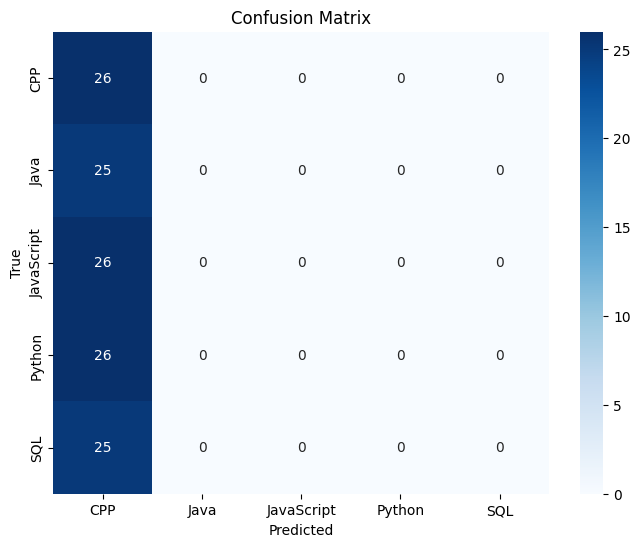


Total training time: 154.28 seconds


(DistilBERTClassifier(
   (distilbert): DistilBertModel(
     (embeddings): Embeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (transformer): Transformer(
       (layer): ModuleList(
         (0-5): 6 x TransformerBlock(
           (attention): DistilBertSdpaAttention(
             (dropout): Dropout(p=0.1, inplace=False)
             (q_lin): Linear(in_features=768, out_features=768, bias=True)
             (k_lin): Linear(in_features=768, out_features=768, bias=True)
             (v_lin): Linear(in_features=768, out_features=768, bias=True)
             (out_lin): Linear(in_features=768, out_features=768, bias=True)
           )
           (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
           (ffn): FFN(
             (dropout): Dropout(p=0.1, inplace=F

In [106]:
distilbertClassifierOut(X, y)

In [107]:
import torch
import torch.nn as nn
import numpy as np
from transformers import DistilBertTokenizer, DistilBertModel
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.sparse as sp
import time
from datetime import datetime

class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        if sp.issparse(texts):
            self.texts = texts.toarray()
        else:
            self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return self.texts.shape[0]
    
    def __getitem__(self, idx):
        text = ' '.join(map(str, self.texts[idx]))
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

class DistilBERTClassifier(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.distilbert = DistilBertModel.from_pretrained('distilbert-base-uncased')
        self.dropout = nn.Dropout(0.1)
        self.classifier = nn.Linear(self.distilbert.config.hidden_size, n_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.distilbert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]
        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

def distilbertClassifierOut(X, y, save_path='./notebooks', batch_size=32, epochs=5, learning_rate=2e-5):
    start_time = time.time()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Label encoding
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    n_classes = len(label_encoder.classes_)
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    print(f"Number of classes: {n_classes}")
    
    # Initialize tokenizer and model
    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBERTClassifier(n_classes).to(device)
    
    # Create datasets and dataloaders
    train_dataset = TextDataset(X_train, y_train, tokenizer)
    test_dataset = TextDataset(X_test, y_test, tokenizer)
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=0
    )
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size,
        num_workers=0
    )
    
    # Initialize optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    
    print(f"\nStarting training at {datetime.now().strftime('%H:%M:%S')}")
    print(f"Batch size: {batch_size}, Epochs: {epochs}")
    print(f"Total batches per epoch: {len(train_loader)}")
    
    # Training loop
    for epoch in range(epochs):
        epoch_start = time.time()
        model.train()
        total_loss = 0
        
        for batch_idx, batch in enumerate(train_loader):
            batch_start = time.time()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            if batch_idx % 5 == 0:  # Print every 5 batches
                batch_time = time.time() - batch_start
                print(f'Epoch {epoch+1}/{epochs} | Batch {batch_idx}/{len(train_loader)} | '
                      f'Loss: {loss.item():.4f} | Batch time: {batch_time:.2f}s')
        
        epoch_time = time.time() - epoch_start
        avg_loss = total_loss / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs} completed | Avg Loss: {avg_loss:.4f} | '
              f'Time: {epoch_time:.2f}s')
    
    print("\nEvaluating model...")
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    print("\nClassification Report:\n",
          classification_report(all_labels, all_preds, 
                             target_names=label_encoder.classes_))
    
    # Plot confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_
    )
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    if save_path:
        model_dict = {
            "model_state_dict": model.state_dict(),
            "label_encoder": label_encoder,
            "tokenizer": tokenizer,
        }
        torch.save(model_dict, save_path)
        print(f"Model saved to {save_path}")
    
    total_time = time.time() - start_time
    print(f"\nTotal training time: {total_time:.2f} seconds")
    
    return model, tokenizer, label_encoder

Using device: cpu
Training set shape: (512, 1067)
Test set shape: (128, 1067)
Number of classes: 5

Starting training at 08:49:55
Batch size: 32, Epochs: 5
Total batches per epoch: 16
Epoch 1/5 | Batch 0/16 | Loss: 1.5899 | Batch time: 3.77s
Epoch 1/5 | Batch 5/16 | Loss: 1.6870 | Batch time: 2.32s
Epoch 1/5 | Batch 10/16 | Loss: 1.6264 | Batch time: 2.45s
Epoch 1/5 | Batch 15/16 | Loss: 1.5917 | Batch time: 2.59s
Epoch 1/5 completed | Avg Loss: 1.6343 | Time: 48.00s
Epoch 2/5 | Batch 0/16 | Loss: 1.6352 | Batch time: 2.98s
Epoch 2/5 | Batch 5/16 | Loss: 1.6303 | Batch time: 2.46s
Epoch 2/5 | Batch 10/16 | Loss: 1.6412 | Batch time: 2.44s
Epoch 2/5 | Batch 15/16 | Loss: 1.6225 | Batch time: 2.57s
Epoch 2/5 completed | Avg Loss: 1.6190 | Time: 47.61s
Epoch 3/5 | Batch 0/16 | Loss: 1.6474 | Batch time: 2.71s
Epoch 3/5 | Batch 5/16 | Loss: 1.6348 | Batch time: 2.59s
Epoch 3/5 | Batch 10/16 | Loss: 1.6210 | Batch time: 2.70s
Epoch 3/5 | Batch 15/16 | Loss: 1.6054 | Batch time: 2.97s
Epoch 

/Users/pradnyeshchoudhari/EECE 7205 - LOCAL/Project/eece7205/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pradnyeshchoudhari/EECE 7205 - LOCAL/Project/eece7205/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/pradnyeshchoudhari/EECE 7205 - LOCAL/Project/eece7205/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` paramete


Classification Report:
               precision    recall  f1-score   support

         CPP       0.33      0.12      0.17        26
        Java       0.00      0.00      0.00        25
  JavaScript       0.21      0.96      0.34        26
      Python       0.00      0.00      0.00        26
         SQL       0.00      0.00      0.00        25

    accuracy                           0.22       128
   macro avg       0.11      0.22      0.10       128
weighted avg       0.11      0.22      0.10       128



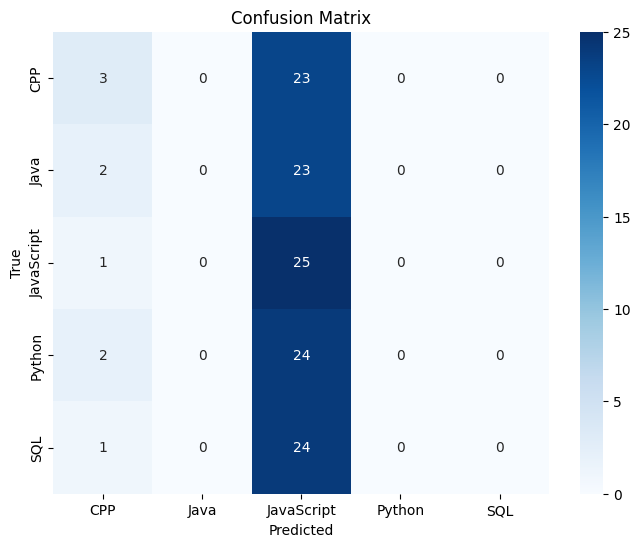

Model saved to ./notebooks

Total training time: 248.01 seconds


(DistilBERTClassifier(
   (distilbert): DistilBertModel(
     (embeddings): Embeddings(
       (word_embeddings): Embedding(30522, 768, padding_idx=0)
       (position_embeddings): Embedding(512, 768)
       (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
       (dropout): Dropout(p=0.1, inplace=False)
     )
     (transformer): Transformer(
       (layer): ModuleList(
         (0-5): 6 x TransformerBlock(
           (attention): DistilBertSdpaAttention(
             (dropout): Dropout(p=0.1, inplace=False)
             (q_lin): Linear(in_features=768, out_features=768, bias=True)
             (k_lin): Linear(in_features=768, out_features=768, bias=True)
             (v_lin): Linear(in_features=768, out_features=768, bias=True)
             (out_lin): Linear(in_features=768, out_features=768, bias=True)
           )
           (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
           (ffn): FFN(
             (dropout): Dropout(p=0.1, inplace=F

In [110]:
X = tfidf.fit_transform(df_labeled["Processed_Text"])
y = df_labeled["Label"]
distilbertClassifierOut(X,y)

In [112]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
n_classes = len(label_encoder.classes_)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [116]:
train_dataset = TextDataset(X_train, y_train, tokenizer)
test_dataset = TextDataset(X_test, y_test, tokenizer)

NameError: name 'tokenizer' is not defined

In [117]:
from transformers import AutoTokenizer

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tokenize_data(X_train):
    return tokenizer(X_train, truncation=True)

tokenized_train = train_dataset.map(tokenize_data, batched=True)
tokenized_test = test_dataset.map(tokenize_data, batched=True)

NameError: name 'train_dataset' is not defined

In [121]:
# Importing the libraries needed
import pandas as pd
import torch
import transformers
from torch.utils.data import Dataset, DataLoader
from transformers import DistilBertModel, DistilBertTokenizer

In [118]:
MAX_LEN = 512
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 2
EPOCHS = 1
LEARNING_RATE = 1e-05
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

In [119]:
class Triage(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.TITLE[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.ENCODE_CAT[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [123]:
type(X)

scipy.sparse._csr.csr_matrix

In [125]:
X = df_labeled['Title']

In [126]:
type(X)

pandas.core.series.Series

In [127]:
# Creating the dataset and dataloader for the neural network
df = X
train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=200)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = Triage(train_dataset, tokenizer, MAX_LEN)
testing_set = Triage(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (640,)
TRAIN Dataset: (512,)
TEST Dataset: (128,)


In [128]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [129]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model. 

class DistillBERTClass(torch.nn.Module):
    def __init__(self):
        super(DistillBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, 4)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [131]:
device = 'cpu'

In [132]:
model = DistillBERTClass()
model.to(device)

DistillBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(

In [133]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [134]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [141]:
batch_size = TRAIN_BATCH_SIZE

In [149]:
def train(X_train, y_train, epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    
    # Loop through each batch in X_train and y_train
    for i in range(0, X_train.shape[0], batch_size):
        # Select the batch data
        ids = X_train[i:i + batch_size].to(device, dtype=torch.long)
        targets = y_train[i:i + batch_size].to(device, dtype=torch.long)
        
        # Forward pass
        outputs = model(ids)
        loss = loss_function(outputs, targets)
        
        # Accumulate loss and calculate accuracy
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calculate_accu(big_idx, targets)
        
        nb_tr_steps += 1
        nb_tr_examples += targets.size(0)
        
        # Logging every 5000 steps
        if i % 5000 == 0:
            loss_step = tr_loss / nb_tr_steps
            accu_step = (n_correct * 100) / nb_tr_examples
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Epoch results
    epoch_loss = tr_loss / nb_tr_steps
    epoch_accu = (n_correct * 100) / nb_tr_examples
    print(f"The Total Accuracy for Epoch {epoch}: {epoch_accu}")
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return epoch_loss, epoch_accu


In [150]:
for epoch in range(EPOCHS):
    train(X_train, y_train, epoch)

AttributeError: to not found

In [139]:
a = 10